In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading the data
df = pd.read_csv(r"https://raw.githubusercontent.com/ItsmeBlackOps/Datasets/main/DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv")

#finding significant null columns
n = pd.DataFrame(df.isna().sum()).rename(columns = {0:'nulls'})
n['freq'] = n['nulls']/len(df)
print(n[n['freq']>0])
print("\n")

#Variable BENE_DEATH_DT  is not significant since 98.44% of data is null the correct way would be to drop this column since it's insignificant for a model
df = df.drop(columns = {'BENE_DEATH_DT'})
print("\n")

#There are no other variables with null values 
print("BENE_BIRTH_DT is not in date_time format for e.g. the first date",df['BENE_BIRTH_DT'].head(1)[0])
print("\n")

#correcting the date_time for 'BENE_BIRTH_DT'
df['BENE_BIRTH_DT'] = pd.to_datetime(df['BENE_BIRTH_DT'], format = "%Y%m%d")
print("\n")

#DESYNPUF_ID is unique and non null as a primary key which wouldn't play a significant role in the model dropping the same
print(df['DESYNPUF_ID'].value_counts().sort_values(ascending = False).head(1))
df = df.drop(columns = {"DESYNPUF_ID"})

#The day in Birth date plays no significant role since all of them are 1 check below the unique values of days is only [1]
print(df['BENE_BIRTH_DT'].dt.day.unique())

# BENE_ESRD_IND has two variables 0 and Y this can be converted to rather 0 and 1 as integer
df['BENE_ESRD_IND'] = df['BENE_ESRD_IND'].replace('Y','1').astype(int)

                nulls      freq
BENE_DEATH_DT  114538  0.984409




BENE_BIRTH_DT is not in date_time format for e.g. the first date 19230501




DESYNPUF_ID
00013D2EFD8E45D1    1
Name: count, dtype: int64
[1]


For value 2 in SP_DIABETES there is a huge drop of counts after 1945, same is with value 1 but in negligible way


(<Axes: xlabel='BENE_BIRTH_DT'>, <Axes: xlabel='BENE_BIRTH_DT'>)

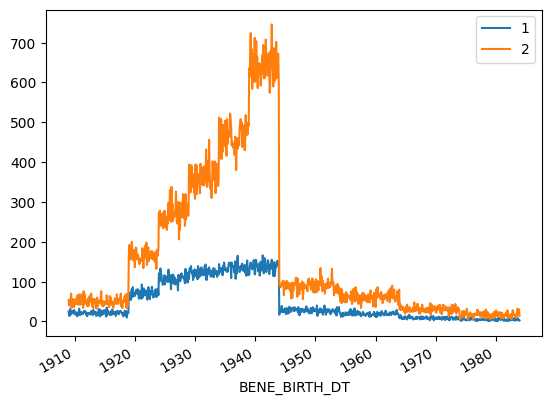

In [3]:
oned = df[df['SP_DIABETES']==1].groupby('BENE_BIRTH_DT').sum('SP_DIABETES')['SP_DIABETES'].sort_values(ascending = False).rename(1)
twod = df[df['SP_DIABETES']==2].groupby('BENE_BIRTH_DT').sum('SP_DIABETES')['SP_DIABETES'].sort_values(ascending = False).rename(2)
print("For value 2 in SP_DIABETES there is a huge drop of counts after 1945, same is with value 1 but in negligible way")
oned.plot(legend = 1), twod.plot(legend = 2)

<Axes: >

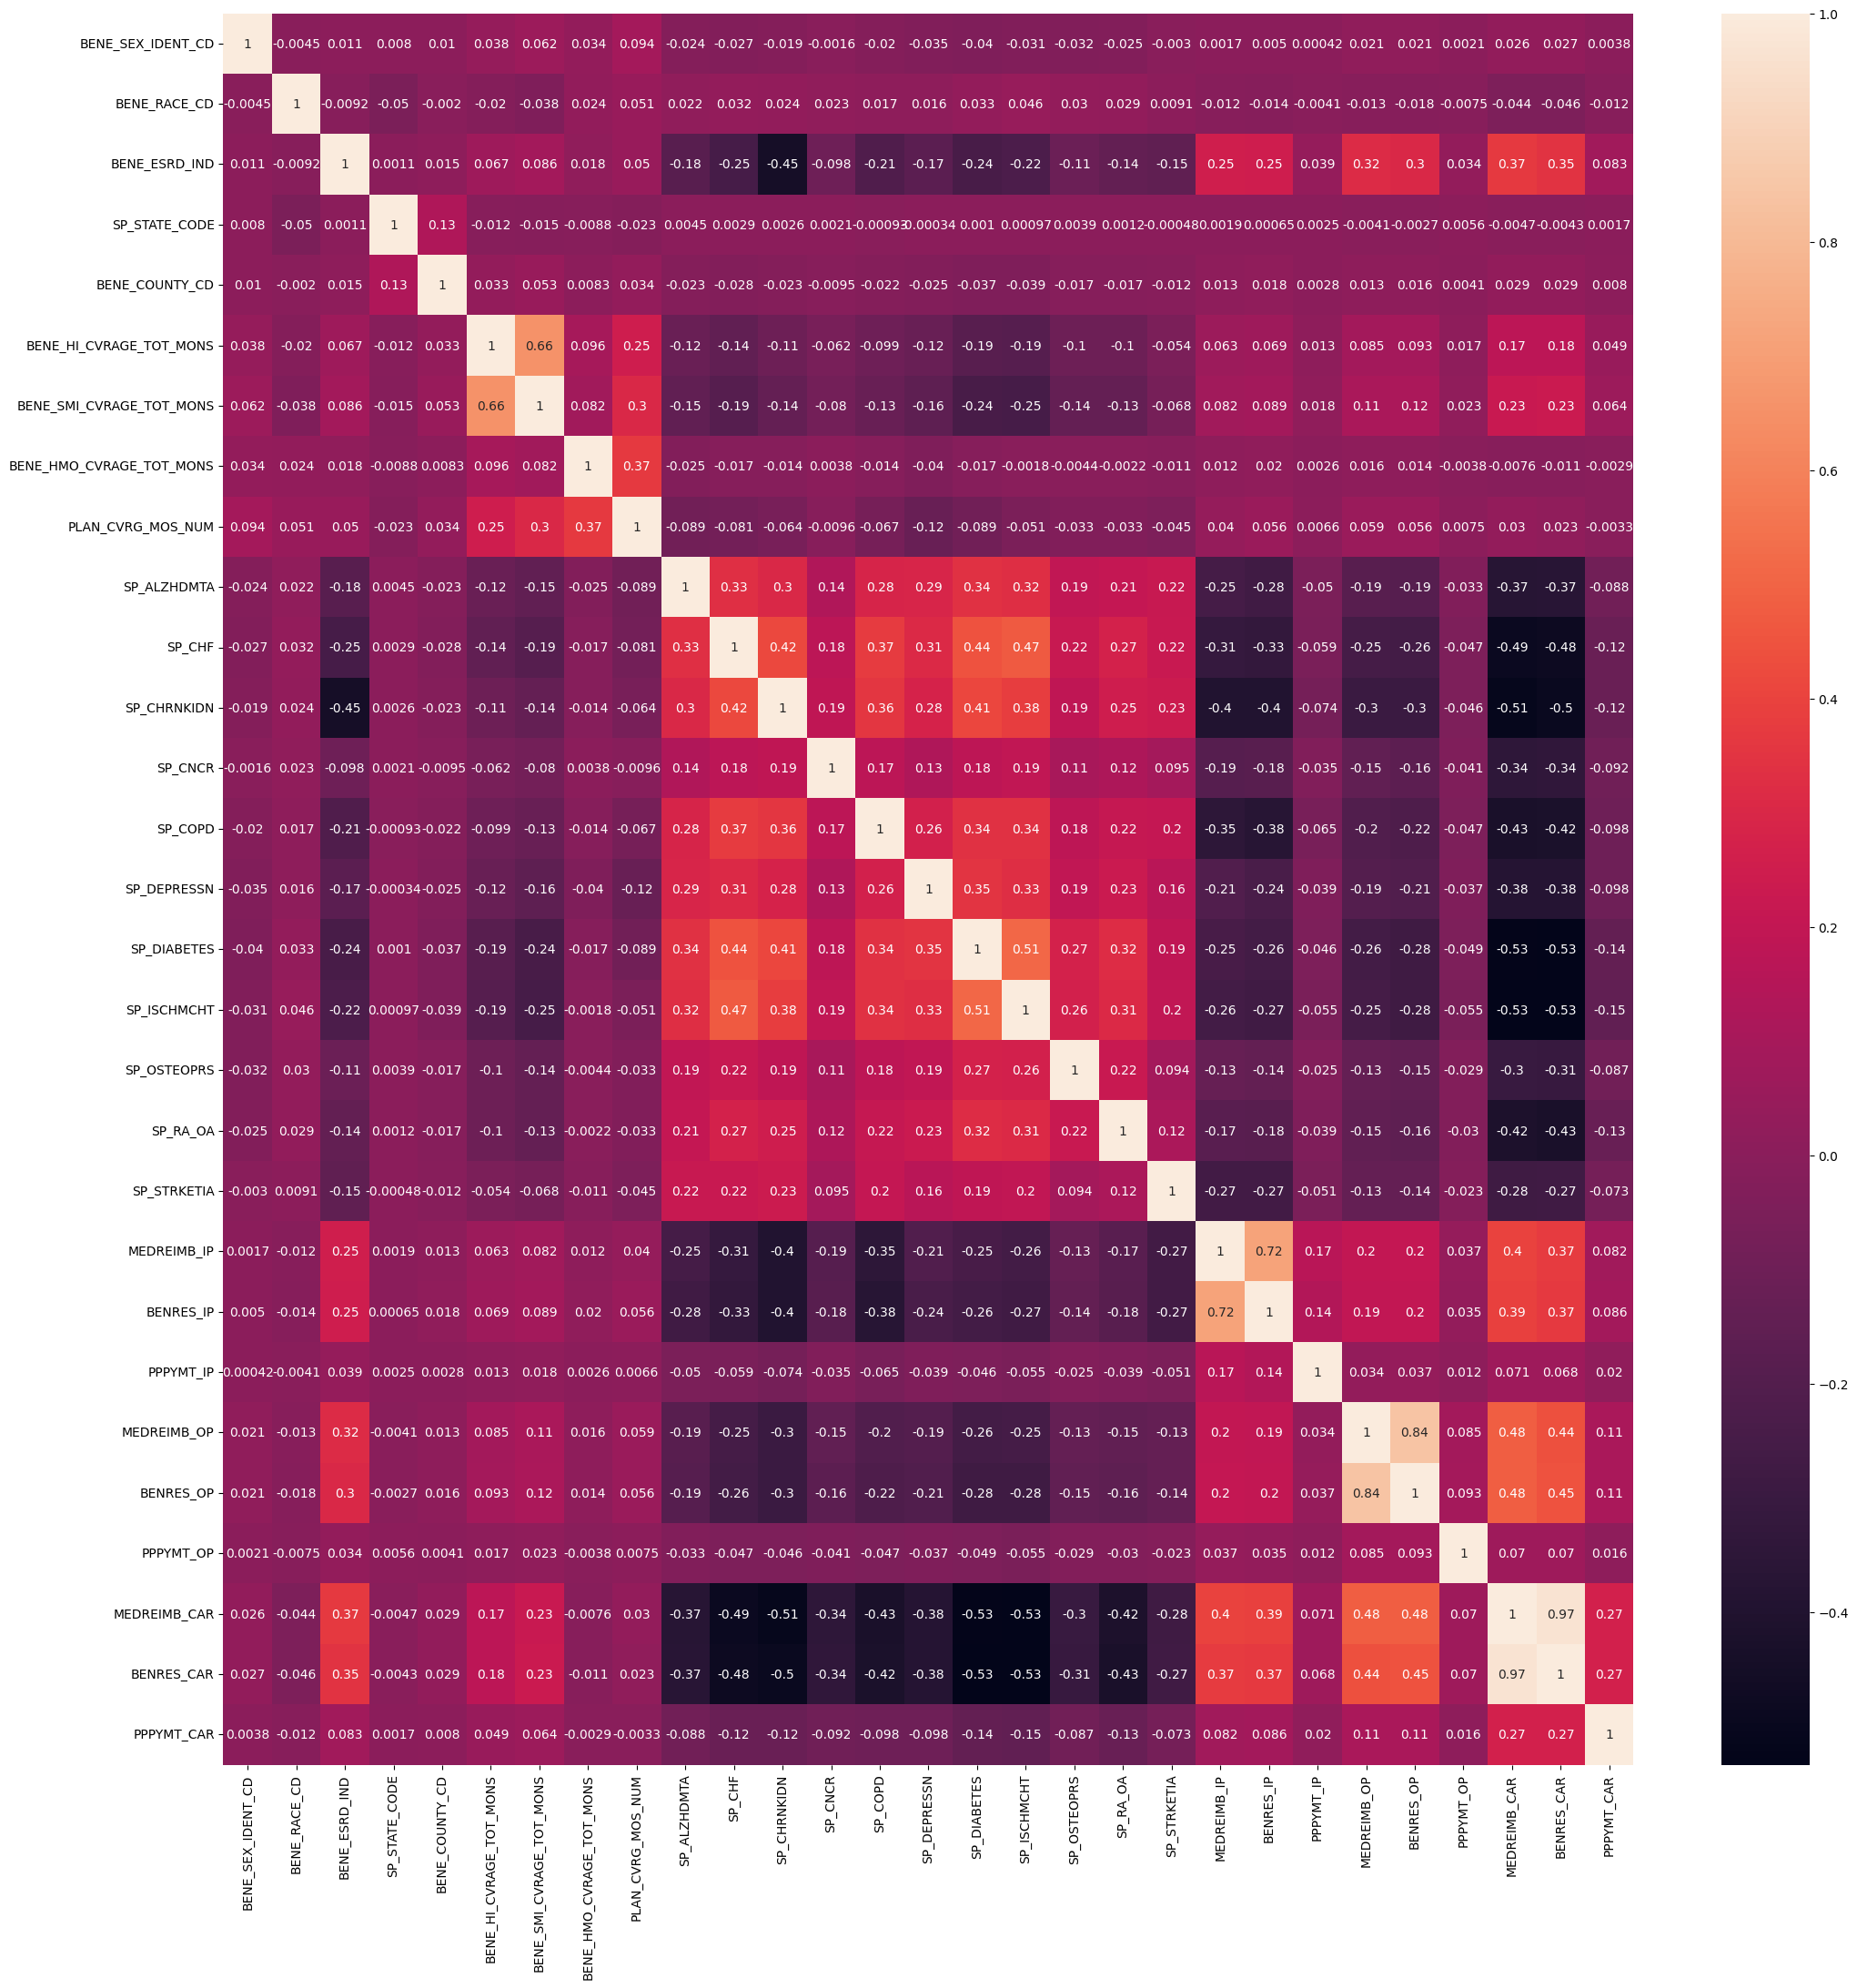

In [4]:
plt.figure(figsize = (25,25))
sns.heatmap(df.iloc[:,1:].corr(), annot = True)
#The below Corr chart shows SP_diabetes is positively correlated to SP_ISCHMCHT as the max with 0.51 corr and negatively correlated with 'MEDREIMB_CAR' and 'BENRES_CAR' with -0.53 as min for both

# Model to predict Target 'SP_DIABETES'

In [5]:
df = df[['BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_ESRD_IND', 'SP_STATE_CODE',
       'BENE_COUNTY_CD', 'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
       'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN',
        'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
       'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
       'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR','SP_DIABETES']]

In [50]:
#As seen below there is a class imbalance in this Sample data set we need to balance this using SMOTE oversampling
print(y.value_counts())

SP_DIABETES
2    72292
1    44060
Name: count, dtype: int64

In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier,XGBRFClassifier
from sklearn.svm import LinearSVC
X = df.iloc[:,:-1]
#Normalizing the values since there is vast deviation in certain variables
X = Normalizer().fit_transform(X)
y = df.iloc[:,-1]
oversample = SMOTE()
X,y = oversample.fit_resample(X,y)

In [52]:
model = LogisticRegression(random_state = 42 )
model.fit(X,y)
result = cross_val_score(estimator = model,X=X,y=y,cv=10)
logreg_result = result.mean()
print(logreg_result)

0.7925289988833294


In [53]:
model = GaussianNB()
model.fit(X,y)
result = cross_val_score(estimator = model,X=X,y=y,cv=10)
gnb_result = result.mean()
print(gnb_result)

0.7034734306422371


In [54]:
model = DecisionTreeClassifier()
model.fit(X,y)
result = cross_val_score(estimator = model,X=X,y=y,cv=10)
dtree_result = result.mean()
print(dtree_result)

0.7714211671219091


In [56]:
model = KNeighborsClassifier()
model.fit(X,y)
result = cross_val_score(estimator = model,X=X,y=y,cv=10)
knn_result = result.mean()
print(knn_result)

0.7974815394507397


In [55]:
model = XGBClassifier()
yk = y.replace({1:0,2:1})
model.fit(X,yk)
result = cross_val_score(estimator = model,X=X,y=yk,cv=10)
xgbc_result = result.mean()
print(xgbc_result)

0.823750258923513


In [57]:
model = XGBRFClassifier()
yk = y.replace({1:0,2:1})
model.fit(X,yk)
result = cross_val_score(estimator = model,X=X,y=yk,cv=10)
xgbrfc_result = result.mean()
print(xgbrfc_result)

0.8106985880032982


In [58]:
model = LinearSVC()
model.fit(X,y)
result = cross_val_score(estimator = model,X=X,y=y,cv=10)
lsvc_result = result.mean()
print(lsvc_result)

0.7922869021100787


In [59]:
#XGBoost Classifier seems to be the accurate model than all
ab = pd.DataFrame([{
    'Logistic_Regression':logreg_result,
    'Naive_Bayes':gnb_result,
    'Decision_Tree':dtree_result,
    'KNeighbors':knn_result,
    'XGB':xgbc_result,
    'XGBRF':xgbrfc_result,
    'LinearSVC':lsvc_result
}]).T.rename(columns = {0:'accuracy'}).sort_values('accuracy',ascending = False)
print(ab)

                     accuracy
XGB                  0.823750
XGBRF                0.810699
KNeighbors           0.797482
Logistic_Regression  0.792529
LinearSVC            0.792287
Decision_Tree        0.771421
Naive_Bayes          0.703473


### This is to let you know that XGBoost Classifier only uses 0,1  as binary mode; and cannot accept 1,2 so I have replaced as above 1 as 0 and 2 as 1. At the end after prediction it is necessary to convert the same reversely

### Finally the suitable model is of 82.37% as XGBoost Classifier